# Final Project
### Notebook written by: Joshua Grou

# EfficientNetV2-S

EfficientNetV2-S is designed to be a very small and fast training network that achieves accuracy similar to that of complex networks that take a very long time to train. This is ideal for this type of project as we will be able to explore the implementation of training and optimization of neural networks without requiring very powerful computational resources.

In [1]:
from torchvision.models import efficientnet_v2_s
from torch.optim import lr_scheduler
from torch import nn
from torch import optim
import time
import copy
import os
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

# 1. Create Data Sets

In [19]:
batch_size = 32
num_workers = 8

transform= torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),ToTensor()])

training_data = torchvision.datasets.ImageFolder(r'C:\Users\joshg\Desktop\Stevens Notes\Fall 2022\Applied Machine Learning\Final Project\Applied_ML_Final\Data/train', transform = transform)
testing_data = torchvision.datasets.ImageFolder(r'C:\Users\joshg\Desktop\Stevens Notes\Fall 2022\Applied Machine Learning\Final Project\Applied_ML_Final\Data/test', transform = transform)
validation_data = torchvision.datasets.ImageFolder(r'C:\Users\joshg\Desktop\Stevens Notes\Fall 2022\Applied Machine Learning\Final Project\Applied_ML_Final\Data/valid', transform = transform)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, num_workers = num_workers)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers = num_workers)

# 2. Create Model and Optimzer

Use cross entropy as the loss for the model and ADAM optimizer with small learning rate of 0.001. Here we will start using a model that does not have pre-trained weights, we will also explore a model that uses pre-trained weights and apply transfer learning to it.

In [4]:
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_v2_s(pre_trained=True)
model.classifier = nn.Linear(1280, 450)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=lr)


# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 3. Train the Model

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

model.train()

total_step = len(train_loader)
curr_lr = lr
best_score = 0
num_epochs = 10
model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        g_labels = model(images)
        loss = criterion(g_labels, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), len(training_data)))
            
    model.eval()
    score = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            g_labels = model(images)

            score += int(torch.max(g_labels, 1)[1][0] == labels[0])
        
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
    avg = score / len(validation_data)
    print('Accuracy: {:.2f}\n'.format(avg))
    model.train()
    
    if best_score < avg:
        best_score = avg
        torch.save(model.state_dict(), './Models/EfficientNetv2_Init.pt')

cuda:0
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 1, Loss: 3.3414
Accuracy: 0.02

3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 2, Loss: 2.2227
Accuracy: 0.02

3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626


# 4. Evalutation of 10 Epoch performance

2250


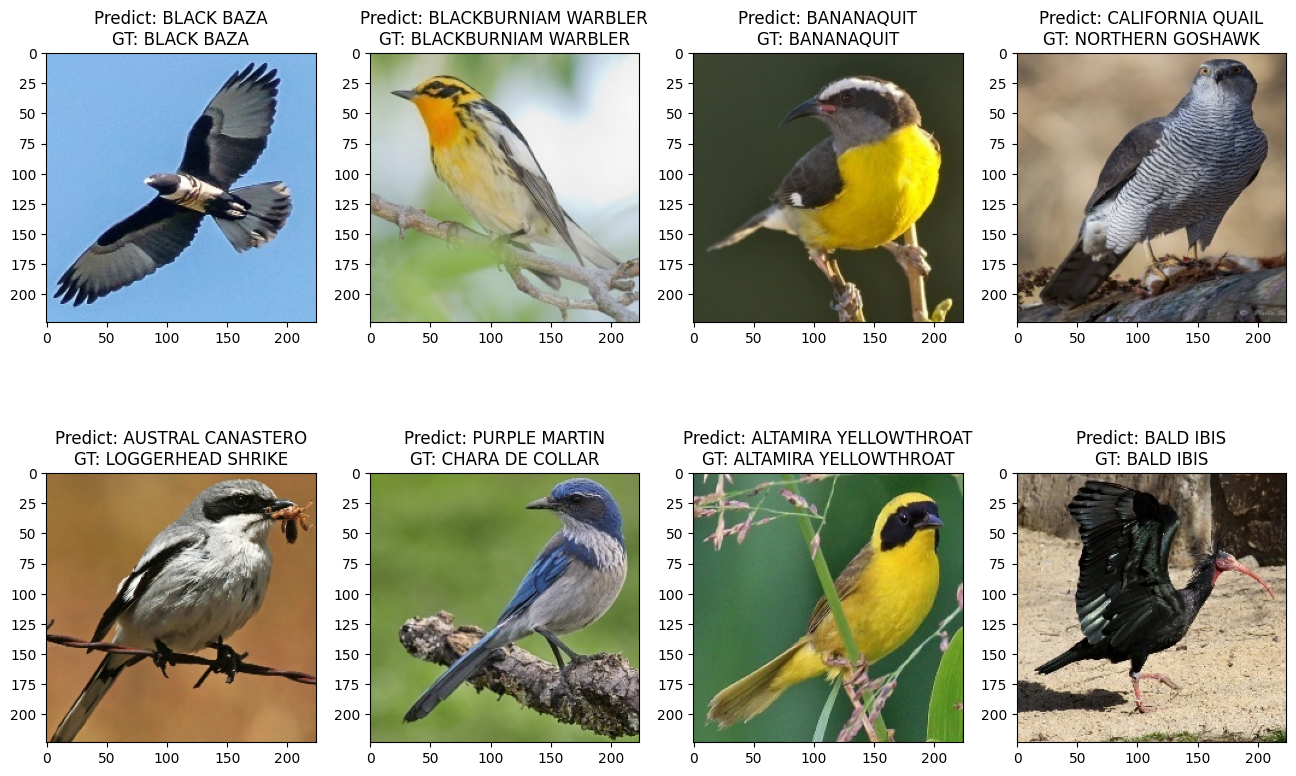

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
model.load_state_dict(torch.load('./Models/EfficientNetv2_init.pt', map_location=device))
model = model.to(device)


class_names = os.listdir('./Data/train/')
class_names.sort()
class_len = len(class_names)


print(len(test_dataset))
_, ax = plt.subplots(2, 4, figsize=(16,10))

for i in range(8):
    data = test_dataset.__getitem__(np.random.choice(range(len(test_dataset))))
    
    image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
    image = image.astype(np.uint32)
    
    label = data[1]
    
    idx = torch.max(model(data[0].unsqueeze(0).to(device)), 1)[1][0].item()
    
    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title('Predict: {}\nGT: {}'.format(class_names[idx], class_names[label]))

We can try to visualize what the convolutional layers are doing here

In [21]:
features = []

hook1 = model.blocks[0].register_forward_hook(hook)
hook2 = model.blocks[1].register_forward_hook(hook)
hook3 = model.blocks[2].register_forward_hook(hook)
hook4 = model.blocks[3].register_forward_hook(hook)

_ = model(data[0].unsqueeze(0).to(device))

hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()

_, ax = plt.subplots(1, 4, figsize=(16,10))
for i in range(len(features)):
    ax[i].imshow(features[i][0].transpose(0, 2).transpose(0, 1).sum(-1).detach().cpu().numpy(), cmap='jet')

AttributeError: 'EfficientNet' object has no attribute 'blocks'

In [21]:
preds = []
gts = []

torch.cuda.empty_cache()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        gts.append(labels)
        preds.append(predicted)

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 82 %


In [26]:
# prepare to count predictions for each class

correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: ABBOTTS BABBLER is 60.0 %
Accuracy for class: ABBOTTS BOOBY is 0.0 %
Accuracy for class: ABYSSINIAN GROUND HORNBILL is 80.0 %
Accuracy for class: AFRICAN CROWNED CRANE is 100.0 %
Accuracy for class: AFRICAN EMERALD CUCKOO is 80.0 %
Accuracy for class: AFRICAN FIREFINCH is 60.0 %
Accuracy for class: AFRICAN OYSTER CATCHER is 80.0 %
Accuracy for class: AFRICAN PIED HORNBILL is 100.0 %
Accuracy for class: ALBATROSS is 80.0 %
Accuracy for class: ALBERTS TOWHEE is 80.0 %
Accuracy for class: ALEXANDRINE PARAKEET is 100.0 %
Accuracy for class: ALPINE CHOUGH is 80.0 %
Accuracy for class: ALTAMIRA YELLOWTHROAT is 40.0 %
Accuracy for class: AMERICAN AVOCET is 80.0 %
Accuracy for class: AMERICAN BITTERN is 80.0 %
Accuracy for class: AMERICAN COOT is 100.0 %
Accuracy for class: AMERICAN FLAMINGO is 80.0 %
Accuracy for class: AMERICAN GOLDFINCH is 100.0 %
Accuracy for class: AMERICAN KESTREL is 100.0 %
Accuracy for class: AMERICAN PIPIT is 100.0 %
Accuracy for class: AMERICAN RE

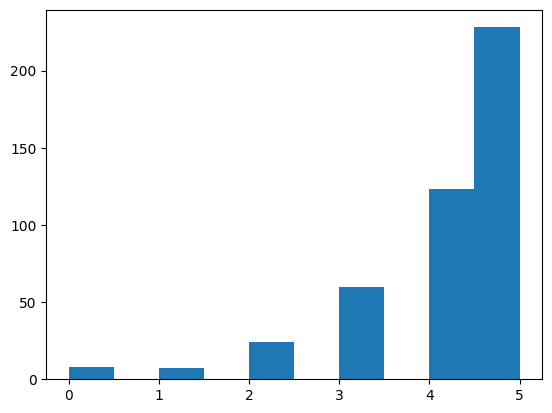

In [31]:
hist_list = []
for classname,correct_count in correct_pred.items():
    hist_list.append(correct_count)
plt.hist(hist_list)
plt.show()

# Code Structure Improvement and Exploration

While the results that were obtained here were good for a first pass it could likely be improved perhaps by training the model for more epochs, before trying this we will however improve the code structure so that it is easier to work with.

In [42]:
def train_model(model,optimizer,criterion,num_epochs,lr, train_loader, validation_loader,training_data, model_save_path):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    model.train()

    total_step = len(train_loader)
    curr_lr = lr
    best_score = 0
    model = model.to(device)
    #iterate over epochs
    for epoch in range(num_epochs):
        total_loss = 0
        #iterate over data sets
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            g_labels = model(images)
            loss = criterion(g_labels, labels)
            #perform backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (i+1) % 100 == 0:
                print('{} / {}'.format(batch_size*(i+1), len(training_data)))
        #check validation accuracy.
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in validation_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = model.forward(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        curr_score = 100 * correct // total
        print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
        print(f'Accuracy of the network on the validation images: {curr_score} %')
        model.train()
        epoch_save_path = model_save_path + str(epoch) + ".pt"
        torch.save(model.state_dict(), epoch_save_path)
            
def evaluate_performance(model,model_save_path,class_names,test_dataset,test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model = model.to(device)
    #display some sample images with their predictions
    _, ax = plt.subplots(2, 4, figsize=(16,10))
    with torch.no_grad():
        for i in range(8):
            data = test_dataset.__getitem__(np.random.choice(range(len(test_dataset))))

            image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
            image = image.astype(np.uint32)

            label = data[1]

            idx = torch.max(model(data[0].unsqueeze(0).to(device)), 1)[1][0].item()

            ax[i//4][i-(i//4)*4].imshow(image)
            ax[i//4][i-(i//4)*4].set_title('Predict: {}\nGT: {}'.format(class_names[idx], class_names[label]))
    #calculate accruacy over entire test set
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model.forward(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[class_names[label]] += 1
                total_pred[class_names[label]] += 1
    #display a histogram of correct predictions by class
        hist_list = []
    for classname,correct_count in correct_pred.items():
        hist_list.append(correct_count)
    plt.figure()
    plt.hist(hist_list)
    plt.title("Histogram of Correct Predictions by Class")
    plt.xlabel("Number of Correct Predictions (Out of 5)")
    plt.ylabel("Number of Classes")
    plt.show()

Now that the evaluation and training code has been better structured lets try to train the model with more epochs this time.

In [10]:
lr = 0.001
num_epochs = 20
model_save_path = "./Models/EfficientNetV2_20Epoch.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_v2_s(pre_trained=True)
model.classifier = nn.Linear(1280, 450)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model(model,optimizer,criterion,num_epochs,lr, train_loader, validation_loader,training_data, model_save_path)

3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 1, Loss: 5.0974
Accuracy of the network on the validation images: 15 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 2, Loss: 3.4826
Accuracy of the network on the validation images: 45 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626

Accuracy of the network on the test images: 93 %


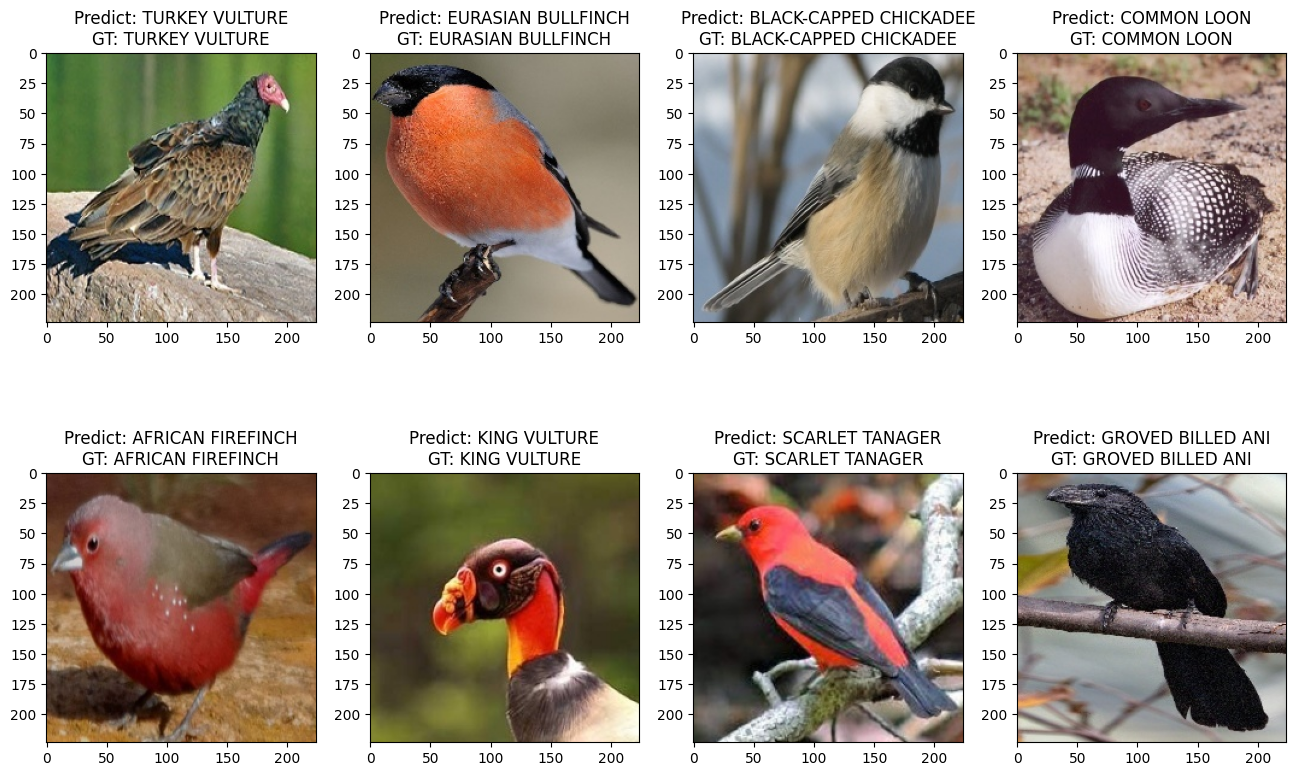

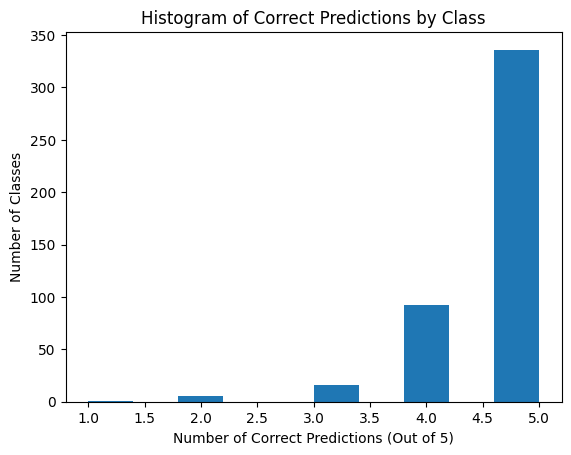

In [20]:
class_names = os.listdir('./Data/train/')
class_names.sort()
class_len = len(class_names)
evaluate_performance(model,model_save_path,class_names,testing_data,test_loader)

# Exploration of Optimal Epoch Selection

So far for a fixed learning rate of 0.001 we have found that there was a change in the accuracy of the model based upon the number of epochs that the model was trained for. In order to determine what might be the best model it might be prudent to train for many epochs and see what kind of accuracy is achieved at each one. Here we will use the validation set to make that determination, however we will save the model at each epoch just in case.

In [7]:
lr = 0.001
num_epochs = 40
model_save_path = "./Models/EfficientNetV2_Epoch_Optim"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_v2_s(pre_trained=True)
model.classifier = nn.Linear(1280, 450)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_model(model,optimizer,criterion,num_epochs,lr, train_loader, validation_loader,training_data, model_save_path)

3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 1, Loss: 5.3740
Accuracy of the network on the validation images: 11 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 2, Loss: 3.6992
Accuracy of the network on the validation images: 43 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626

38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 22, Loss: 0.0884
Accuracy of the network on the validation images: 92 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 23, Loss: 0.0815
Accuracy of the network on the validation images: 92 %
3200 / 70626
6400 / 70626
9600 / 70626
12800 / 70626
16000 / 70626
19200 / 70626
22400 / 70626
25600 / 70626
28800 / 70626
32000 / 70626
35200 / 70626
38400 / 70626
41600 / 70626
44800 / 70626
48000 / 70626
51200 / 70626
54400 / 70626
57600 / 70626
60800 / 70626
64000 / 70626
67200 / 70626
70400 / 70626
Epoch: 24, Loss: 0.0785
Accuracy of the network on the validation images: 91 %

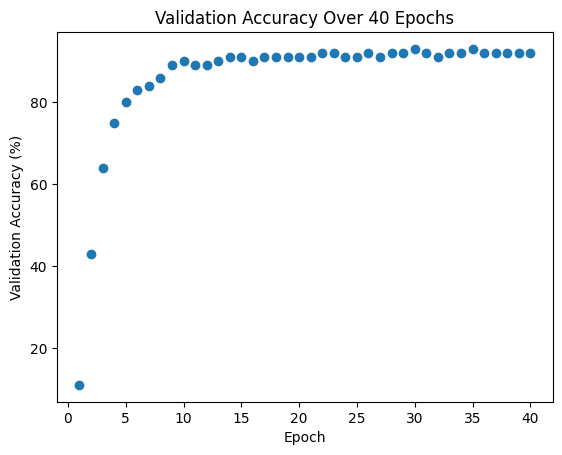

In [45]:
 epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
 31,32,33,34,35,36,37,38,39,40]
 
 accuracy = [11,43,64,75,80,83,84,86,89,90,89,89,90,91,91,90,91,91,91,91,91,92,92,91,91,92,91,92,
92,93,92,91,92,92,93,92,92,92,92,92]
    
plt.scatter(epoch,accuracy)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Over 40 Epochs")
plt.show()

From this work it seems like 30 epochs is a good selection for the amount to train, so we can reload that models weights and evaluate it on the testing dataset.

Accuracy of the network on the test images: 93 %


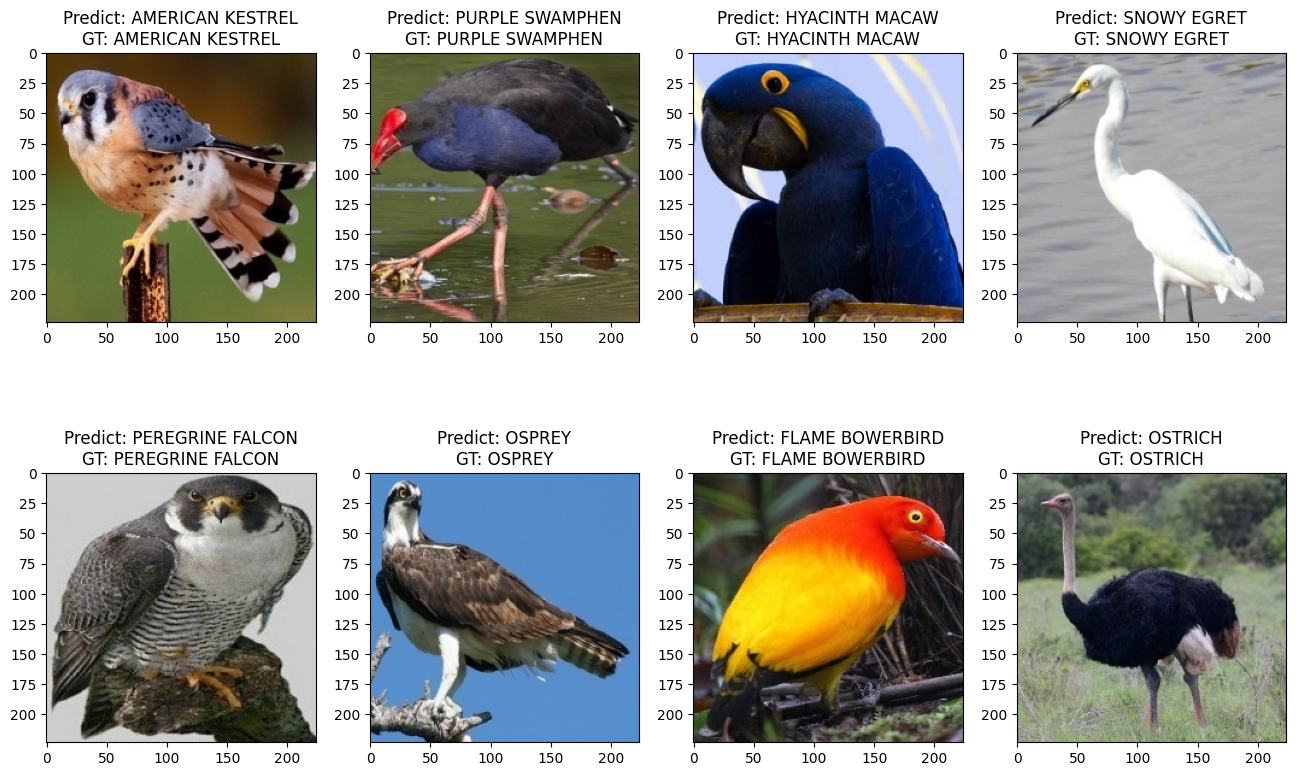

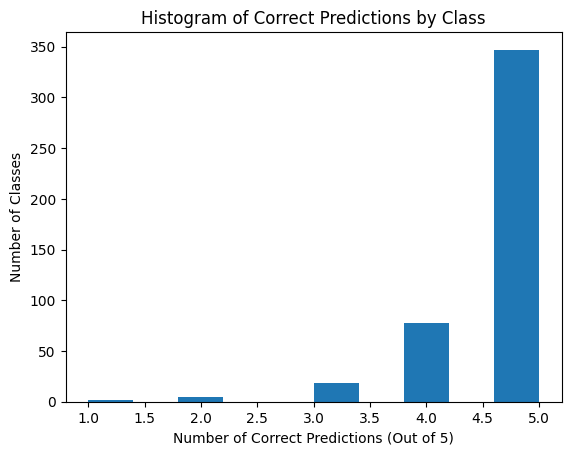

In [46]:
model_save_path = "./Models/EfficientNetV2_Epoch_Optim29.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_v2_s(pre_trained=True)
model.classifier = nn.Linear(1280, 450)
class_names = os.listdir('./Data/train/')
class_names.sort()
class_len = len(class_names)
evaluate_performance(model,model_save_path,class_names,testing_data,test_loader)

# Ray Tune


In [33]:
def train_tuning(model, optimizer, train_loader, num_epochs, criterion):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    model.train()
    total_step = len(train_loader)
    best_score = 0
    model = model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            g_labels = model(images)
            loss = criterion(g_labels, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("epoch " + str(epoch) + " complete")
    return model
            
            
def test_tuning(model, test_loader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model.forward(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (100*correct)/total
    return acc  

In [34]:
import torch
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch


# 1. Wrap a PyTorch model in an objective function.
def objective(config):
    model = efficientnet_v2_s(pre_trained=True)
    model.classifier = nn.Linear(1280, 450)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # Tune the optimizer
    optimizer = optim.Adam(
        model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"],
        betas = (config["beta_1"], config["beta_2"])
    )

    while True:
        model = train_tuning(model, optimizer, train_loader, config["num_epochs"],criterion)  # Train the model
        acc = test_tuning(model, validation_loader)  # Compute test accuracy
        session.report({"mean_accuracy": acc})  # Report to Tune


# 2. Define a search space and initialize the search algorithm.
search_space = {"lr": tune.loguniform(0.0001, 0.1), "weight_decay": tune.uniform(0, 0.3),
               "beta_1": tune.uniform(0.8, 0.9),
               "beta_2": tune.uniform(0.8, 0.999),
               "num_epochs": tune.randint(10, 41)}
algo = OptunaSearch()

# 3. Start a Tune run that maximizes mean accuracy and stops after 5 iterations.
trainable_with_resources = tune.with_resources(objective, {"cpu": 12,"gpu":1})
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        metric="mean_accuracy",
        mode="max",
        search_alg=algo,
        num_samples=30
    ),
    run_config=air.RunConfig(
        stop={"training_iteration": 1},
        local_dir="./results", 
        name="Ray-Tune-Test"
    ),
    param_space=search_space,
)
results = tuner.fit()
print("Best Score is: ", results.get_best_result())
print("Best config is:", results.get_best_result().config)

C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\ray\tune\search\optuna\optuna_search.py:673: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return ot.distributions.LogUniformDistribution(
C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\ray\tune\search\optuna\optuna_search.py:682: FutureWarning: UniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return ot.distributions.UniformDistribution(
C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\ray\tune\search\optuna\optuna_search.py:694: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\optuna\distributions.py:766: FutureWarning: LogUniformDistribution(high=0.1, low=0.0001) is deprecated and internally converted to FloatDistribution(high=0.1, log=True, low=0.0001, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\optuna\distributions.py:766: FutureWarning: UniformDistribution(high=0.3, low=0.0) is deprecated and internally converted to FloatDistribution(high=0.3, log=False, low=0.0, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
C:\Users\joshg\anaconda3\envs\Applied_ML_Final\lib\site-packages\optuna\distributions.py:766: FutureWarning: UniformDistribution(high=0.9, low=0.8) is deprecated and internally converted to FloatDistribution(high=0.9, log=False, low=0.8, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.w

(objective pid=24056) epoch 0 complete
(objective pid=24056) epoch 1 complete
(objective pid=24056) epoch 2 complete
(objective pid=24056) epoch 3 complete
(objective pid=24056) epoch 4 complete
(objective pid=24056) epoch 5 complete
(objective pid=24056) epoch 6 complete
(objective pid=24056) epoch 7 complete
(objective pid=24056) epoch 8 complete
(objective pid=24056) epoch 9 complete
(objective pid=24056) epoch 10 complete
(objective pid=24056) epoch 11 complete


(objective pid=24056) epoch 0 complete
(objective pid=24056) epoch 1 complete
(objective pid=24056) epoch 2 complete
(objective pid=24056) epoch 3 complete
(objective pid=24056) epoch 4 complete
(objective pid=24056) epoch 5 complete
(objective pid=24056) epoch 6 complete
(objective pid=24056) epoch 7 complete
(objective pid=24056) epoch 8 complete
(objective pid=24056) epoch 9 complete
(objective pid=24056) epoch 10 complete
(objective pid=24056) epoch 11 complete
(objective pid=24056) epoch 12 complete
(objective pid=24056) epoch 13 complete
(objective pid=24056) epoch 14 complete
(objective pid=24056) epoch 15 complete
(objective pid=24056) epoch 16 complete
(objective pid=24056) epoch 17 complete
(objective pid=24056) epoch 18 complete
(objective pid=24056) epoch 19 complete
(objective pid=24056) epoch 20 complete
(objective pid=24056) epoch 21 complete
(objective pid=24056) epoch 22 complete
(objective pid=24056) epoch 23 complete
(objective pid=24056) epoch 24 complete
(objective

(objective pid=24056) epoch 20 complete
(objective pid=24056) epoch 21 complete
(objective pid=24056) epoch 22 complete
(objective pid=24056) epoch 23 complete
(objective pid=24056) epoch 24 complete
(objective pid=24056) epoch 25 complete
(objective pid=24056) epoch 26 complete
(objective pid=24056) epoch 27 complete
(objective pid=24056) epoch 28 complete
(objective pid=24056) epoch 29 complete
(objective pid=24056) epoch 30 complete
(objective pid=24056) epoch 31 complete
(objective pid=24056) epoch 32 complete
(objective pid=24056) epoch 33 complete
(objective pid=24056) epoch 34 complete
(objective pid=24056) epoch 35 complete
(objective pid=24056) epoch 36 complete
(objective pid=24056) epoch 37 complete
(objective pid=24056) epoch 38 complete
(objective pid=24056) epoch 39 complete
(objective pid=24056) epoch 0 complete
(objective pid=24056) epoch 1 complete
(objective pid=24056) epoch 2 complete
(objective pid=24056) epoch 3 complete
(objective pid=24056) epoch 4 complete
(obje

2022-12-11 19:48:36,787	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2022-12-11 19:48:41,013	ERROR tune.py:758 -- Trials did not complete: [objective_4efb4696, objective_8e5c05d9]
2022-12-11 19:48:41,013	INFO tune.py:762 -- Total run time: 81723.41 seconds (81723.02 seconds for the tuning loop).
2022-12-11 19:48:41,013	WARNING tune.py:768 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Best Score is:  Result(metrics={'mean_accuracy': 0.2222222222222222, 'done': True, 'trial_id': 'ae655dfb', 'experiment_tag': '1_beta_1=0.8557,beta_2=0.9928,lr=0.0005,num_epochs=12,weight_decay=0.0694'}, error=None, log_dir=WindowsPath('C:/Users/joshg/Desktop/Stevens Notes/Fall 2022/Applied Machine Learning/Final Project/Applied_ML_Final/results/Ray-Tune-Test/objective_ae655dfb_1_beta_1=0.8557,beta_2=0.9928,lr=0.0005,num_epochs=12,weight_decay=0.0694_2022-12-10_21-06-38'))
Best config is: {'lr': 0.0005096771257856167, 'weight_decay': 0.06943005433770084, 'beta_1': 0.8557111131676274, 'beta_2': 0.992800096024309, 'num_epochs': 12}
